## Using Linear Regression to Predict COVID-19 Excess Mortality

We want to use linear regression to find a connection between countries' demographic factors and their excess mortality during the COVID-19 pandemic.

First, we will focus on the time frame between 03/01/2020 and 12/31/2020. This has several reasons:

- we want to evaluate these factors prior to the introduction of vaccines; those campaigns started at the end of 2020
- many countries have not reported deaths for 2021 yet
- we choose such a long time frame, because the pandemic is highly dynamic and also seasonal with differences between regions and continents; using cumulative excess mortality decreases those differences
- the months prior to March are left out, because during that time the pandemic was not as widespread; excess mortality before March 2021 is most likely not caused by COVID

In [1]:
# Make inline plots vector graphics
%matplotlib inline
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")

# Plotting setup
import matplotlib.pyplot as plt

# Package imports
import numpy as np
import pandas as pd
import datetime
from tueplots import bundles
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score

# Set Pyplot parameters to Neurips template
plt.rcParams.update(bundles.neurips2021(usetex=False))

We start by downloading the COVID data set from [OurWorldInData.org](https://github.com/owid/covid-19-data/tree/master/public/data).

In [2]:
# Link to world-wide data during the COVID pandemic
url = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv"

# Read CSV data from URL
data_owid = pd.read_csv(url)

# Parse data
data_owid["date"] = pd.to_datetime(data_owid.date, format="%Y-%m-%d")

# Inspect dataframe and datatypes
display(data_owid.head())
data_owid.dtypes[0:5]

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
0,AFG,Asia,Afghanistan,2020-02-24,5.0,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
1,AFG,Asia,Afghanistan,2020-02-25,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
2,AFG,Asia,Afghanistan,2020-02-26,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
3,AFG,Asia,Afghanistan,2020-02-27,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN
4,AFG,Asia,Afghanistan,2020-02-28,5.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,37.746,0.5,64.83,0.511,NaN,NaN,NaN,NaN


iso_code               object
continent              object
location               object
date           datetime64[ns]
total_cases           float64
dtype: object

Next, we extract the relevant columns, which are:
- iso_code: ISO 3166-1 alpha-3 – three-letter country codes
- excess_mortality_cumulative: Percentage difference between the cumulative number of deaths since 1 January 2020 and the cumulative projected deaths for the same period based on previous years
- population_density: Number of people divided by land area, measured in square kilometers
- aged_65_older: Share of the population that is 65 years and older, most recent year available
- extreme_poverty: Share of the population living in extreme poverty, most recent year available since 2010
- cardiovasc_death_rate: Death rate from cardiovascular disease in 2017 (annual number of deaths per 100,000 people)
- diabetes_prevalence: Diabetes prevalence (% of population aged 20 to 79) in 2017
- hospital_beds_per_thousand: Hospital beds per 1,000 people, most recent year available since 2010

We might later do the same analysis for a different time frame in 2021 to evaluate the influence of the vaccination campaigns. For this reason, we also extract the number of people fully vaccinated:
- people_fully_vaccinated_per_hundred: Total number of people who received all doses prescribed by the vaccination protocol per 100 people in the total population

In [3]:
# Remove columns, that are not needed
newcols = [
    "iso_code",
    "date",
    "excess_mortality_cumulative",
    "population_density",
    "aged_65_older",
    "extreme_poverty",
    "cardiovasc_death_rate",
    "diabetes_prevalence",
    "hospital_beds_per_thousand",
    #"people_fully_vaccinated_per_hundred"
]
data_owid.drop(columns=data_owid.columns.difference(newcols), inplace=True)

print("Shape prior to dropping NaN: ", data_owid.shape)
print("Number of countries: ", len(data_owid.iso_code.unique()))

# Remove entries with missing data
data_owid.dropna(inplace=True)
print("Shape after dropping NaN: ", data_owid.shape)
print("Number of countries: ", len(data_owid.iso_code.unique()))

data_owid.head()

Shape prior to dropping NaN:  (160009, 9)
Number of countries:  238
Shape after dropping NaN:  (3893, 9)
Number of countries:  66


,iso_code,date,population_density,aged_65_older,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,hospital_beds_per_thousand,excess_mortality_cumulative
1443,ALB,2020-02-29,104.871,13.188,1.1,304.195,10.08,2.89,-4.34
1474,ALB,2020-03-31,104.871,13.188,1.1,304.195,10.08,2.89,-2.59
1504,ALB,2020-04-30,104.871,13.188,1.1,304.195,10.08,2.89,-1.17
1535,ALB,2020-05-31,104.871,13.188,1.1,304.195,10.08,2.89,0.24
1565,ALB,2020-06-30,104.871,13.188,1.1,304.195,10.08,2.89,1.65


Next, we group the data by country and select for each the entry closest to the start and end dates.

In [4]:
# Drop excess mortality and date to get only the demographic information for each country
data_demography = data_owid.drop(columns=["date", "excess_mortality_cumulative",])
data_demography.drop_duplicates(inplace=True)

# Select the entries closest to the start and stop dates of the selected time frame
start_date = datetime.datetime(year=2020, month=3, day=1)
end_date = datetime.datetime(year=2020, month=12, day=31)
cols = data_owid[["date", "iso_code", "excess_mortality_cumulative"]]
data_em = cols.copy()
data_em["dif_start"] = (data_em["date"] - start_date).abs()
data_em["dif_end"] = (data_em["date"] - end_date).abs()

# ensure reported dates are not too far away from the desired days
data_em_start = data_em[data_em.dif_start <= datetime.timedelta(days=+31)]
data_em_end = data_em[data_em.dif_end <= datetime.timedelta(days=+31)]

start_indices = data_em_start.groupby('iso_code')['dif_start'].idxmin()
end_indices = data_em_end.groupby('iso_code')['dif_end'].idxmin()

# filter countries that don't have data for both dates
countries_both = start_indices[start_indices.index.isin(end_indices.index)].index
start_indices = start_indices[start_indices.index.isin(countries_both)]
end_indices = end_indices[end_indices.index.isin(countries_both)]
data_demography = data_demography[data_demography.iso_code.isin(countries_both)]

start_diff = data_em_start[data_em_start.index.isin(start_indices)].excess_mortality_cumulative
end_diff = data_em_end[data_em_end.index.isin(end_indices)].excess_mortality_cumulative

# Compute the difference in excess mortality between start and end date for each country
data_demography["em_start"] = list(start_diff)
data_demography["em_end"] = list(end_diff)
data_demography["Cum. excess mortality"] = data_demography.em_end - data_demography.em_start

data_demography.drop(columns=["em_start", "em_end"], inplace=True)

# Rename columns for nicer plots
data_demography.rename(columns={
    "aged_65_older": "Age 65+",
    "population_density": "Population density",
    "extreme_poverty": "Extreme poverty",
    "cardiovasc_death_rate": "Cardiovasc. deaths",
    "diabetes_prevalence": "Diabetes prevalence",
    "hospital_beds_per_thousand": "Hospital beds"}, inplace=True)

data_demography.head()

,iso_code,Population density,Age 65+,Extreme poverty,Cardiovasc. deaths,Diabetes prevalence,Hospital beds,Cum. excess mortality
1443,ALB,104.871,13.188,1.1,304.195,10.08,2.89,31.01
2156,DZA,17.348,6.211,0.5,278.364,6.73,1.90,28.46
5668,ARG,16.177,11.198,0.6,191.032,5.50,5.00,13.04
6436,ARM,102.931,11.232,1.8,341.010,7.11,4.20,37.35
8557,AUS,3.202,15.504,0.5,107.791,5.07,3.84,-2.89


We continue by splitting the data into features and target. The features are normalized to N(0,1) to allow interpreting the linear regression coefficients.

In [5]:
# Split into features X and regression target y
X = data_demography[[
     "Population density",
     "Age 65+",
     "Extreme poverty",
     "Cardiovasc. deaths",
     "Diabetes prevalence",
     "Hospital beds"]]
y = data_demography["Cum. excess mortality"].values

# Normalize features
X = (X - X.mean()) / X.std()

Linear regression is difficult to interprete if there are correlations between different features. To check if this is the case, we plot the correlation coefficients of our features.

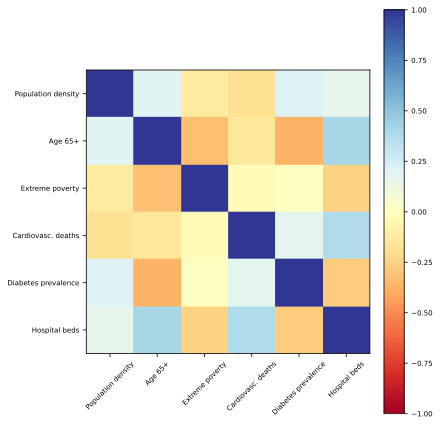

In [6]:
# Plot correlation coefficients
cor = X.corr()

fig, ax = plt.subplots(1,1, figsize=(6, 6))
im = ax.imshow(cor, cmap='RdYlBu', vmin=-1.0, vmax=1.0)

# Set correct labels
labels = X.columns

x_ = range(len(labels))
ax.set_xticks(x_)
ax.set_yticks(x_)

ax.set_xticklabels(labels, rotation=45)
ax.set_yticklabels(labels, rotation=0)

# Show plot. No need to print, because it's not part of the paper.
plt.colorbar(im, ax=ax)
plt.show()

Finally, we are able to train our model and plot the coefficients.

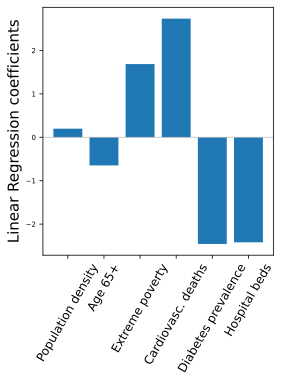

In [7]:
# Fit the model
clf = LinearRegression(fit_intercept=True).fit(X, y)

# Plot the coefficients
fig, ax = plt.subplots(1, 1, figsize=(3.8, 5.2))
ax.axhline(y=0, color="#b0b0b0", linewidth=0.8, alpha=0.8)
ax.bar(x_, clf.coef_)
ax.set_xticks(x_)
ax.set_xticklabels(labels, rotation=60, fontsize=12)
ax.set_ylabel("Linear Regression coefficients", fontsize=15)

# Save and show figure
plt.savefig("fig_linear_regression_em.pdf", bbox_inches="tight")
plt.show()

In [8]:
alpha_values = [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
scores_lasso = []
scores_ridge = []
cv = 5

for a in alpha_values:
    clf_ridge = Ridge(alpha=a, fit_intercept=True)
    s_ridge = np.mean(cross_val_score(clf_ridge, X, y, cv=cv, scoring='neg_root_mean_squared_error'))
    clf_lasso = Lasso(alpha=a, fit_intercept=True, max_iter=10000)
    s_lasso = np.mean(cross_val_score(clf_lasso, X, y, cv=cv, scoring='neg_root_mean_squared_error'))
    print("Ridge: ", s_ridge, " Lasso: ", s_lasso)
    
clf_linear = LinearRegression(fit_intercept=True)
s_linear = np.mean(cross_val_score(clf_linear, X, y, cv=cv, scoring='neg_root_mean_squared_error'))
print("LR: ", s_linear)

Ridge:  -16.528218914911644  Lasso:  -16.526617663767006
Ridge:  -16.526945670933884  Lasso:  -16.51102295328938
Ridge:  -16.51429478278419  Lasso:  -16.37614356805792
Ridge:  -16.39542397665839  Lasso:  -15.344451160310559
Ridge:  -15.667813768647767  Lasso:  -14.433580930995191
Ridge:  -14.654419840675388  Lasso:  -14.433580930995191
Ridge:  -14.451362955905868  Lasso:  -14.433580930995191
LR:  -16.52836047861789


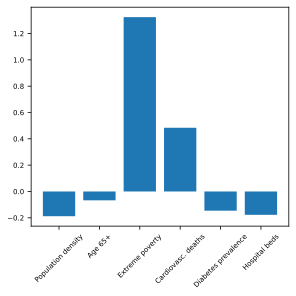

In [9]:
clf_lasso = Lasso(alpha=1, fit_intercept=True).fit(X, y)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.bar(x_, clf_lasso.coef_)
ax.set_xticks(x_)
ax.set_xticklabels(labels, rotation=45)
plt.show();

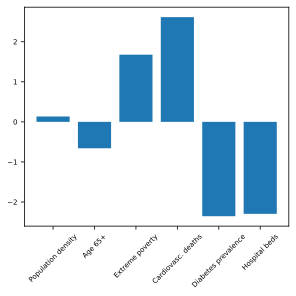

In [10]:
clf_ridge = Ridge(alpha=1, fit_intercept=True).fit(X, y)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.bar(x_, clf_ridge.coef_)
ax.set_xticks(x_)
ax.set_xticklabels(labels, rotation=45)
plt.show();

Plot correlations between all input features and the target.

0 0 Population density (# / sqkm)
0 1 Age 65+ (%)
0 2 Extreme poverty (%)
1 0 Cardiovasc. deaths (# / 100,000)
1 1 Diabetes prevalence (%)
1 2 Hospital beds (# / 1,000)


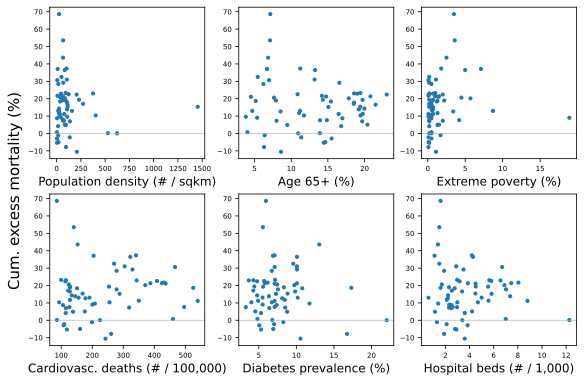

In [11]:
# Rename the columns again to include units
data_demography.rename(columns={
    "Age 65+": "Age 65+ (%)",
    "Population density": "Population density (# / sqkm)",
    "Extreme poverty" : "Extreme poverty (%)",
    "Cardiovasc. deaths": "Cardiovasc. deaths (# / 100,000)",
    "Diabetes prevalence": "Diabetes prevalence (%)",
    "Hospital beds": "Hospital beds (# / 1,000)"}, inplace=True)

# Create the plots
fig, axs = plt.subplots(2, 3, figsize=(8,5.2))

for i in range(len(data_demography.columns)-2):
    row = i // 3
    col = i % 3
    print(row, col, data_demography.columns[i+1])
    axs[row, col].scatter(data_demography.iloc[:,i+1], data_demography["Cum. excess mortality"], s=10)
    axs[row, col].set_xlabel(data_demography.columns[i+1], fontsize=12)
    axs[row, col].axhline(y=0, color="#b0b0b0", linewidth=0.8, alpha=0.8)

fig.supylabel("Cum. excess mortality (%)", fontsize=15)

# Save and show figure
plt.savefig("fig_em_correlation.pdf", bbox_inches="tight")
plt.show()